In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
from glob import glob
import os
import json 
import random
from xgboost import XGBClassifier, XGBRegressor

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
path = '/content/drive/MyDrive/projects/dacon_img_competition/sample'  #코랩사용할경우만

In [5]:
# 분석에 사용할 feature 선택
csv_features = ['내부 온도 1 평균', '내부 온도 1 최고', '내부 온도 1 최저', '내부 습도 1 평균', '내부 습도 1 최고', 
                '내부 습도 1 최저', '내부 이슬점 평균', '내부 이슬점 최고', '내부 이슬점 최저']

# csv_files = sorted(glob('sample_data/*/*.csv'))
allfile = glob(path + '/sample_data/sample_data/*/*.csv')
csv_files = sorted(allfile)

temp_csv = pd.read_csv(csv_files[0])[csv_features]
max_arr, min_arr = temp_csv.max().to_numpy(), temp_csv.min().to_numpy()

# feature 별 최대값, 최솟값 계산
for csv in tqdm(csv_files[1:]):
    temp_csv = pd.read_csv(csv)[csv_features]
    temp_max, temp_min = temp_csv.max().to_numpy(), temp_csv.min().to_numpy()
    max_arr = np.max([max_arr,temp_max], axis=0)
    min_arr = np.min([min_arr,temp_min], axis=0)

# feature 별 최대값, 최솟값 dictionary 생성
csv_feature_dict = {csv_features[i]:[min_arr[i], max_arr[i]] for i in range(len(csv_features))}
csv_feature_dict

100%|██████████| 498/498 [01:21<00:00,  6.12it/s]


{'내부 습도 1 최고': [36.5, 100.0],
 '내부 습도 1 최저': [32.4, 100.0],
 '내부 습도 1 평균': [34.1, 100.0],
 '내부 온도 1 최고': [14.5, 47.6],
 '내부 온도 1 최저': [14.4, 47.0],
 '내부 온도 1 평균': [14.4, 47.3],
 '내부 이슬점 최고': [12.8, 31.9],
 '내부 이슬점 최저': [12.1, 29.1],
 '내부 이슬점 평균': [12.4, 29.9]}

In [6]:
# 제공된 sample data는 파프리카와 시설포도 2종류의 작물만 존재
label_description = {
 '3_00_0': '파프리카_정상',
 '3_a9_1': '파프리카흰가루병_초기',
 '3_a9_2': '파프리카흰가루병_중기',
 '3_a9_3': '파프리카흰가루병_말기',
 '3_a10_1': '파프리카잘록병_초기',
 '3_a10_2': '파프리카잘록병_중기',
 '3_a10_3': '파프리카잘록병_말기',
 '3_b3_1': '칼슘결핍_초기',
 '3_b3_2': '칼슘결핍_중기',
 '3_b3_3': '칼슘결핍_말기',
 '3_b6_1': '다량원소결핍 (N)_초기',
 '3_b6_2': '다량원소결핍 (N)_중기',
 '3_b6_3': '다량원소결핍 (N)_말기',
 '3_b7_1': '다량원소결핍 (P)_초기',
 '3_b7_2': '다량원소결핍 (P)_중기',
 '3_b7_3': '다량원소결핍 (P)_말기',
 '3_b8_1': '다량원소결핍 (K)_초기',
 '3_b8_2': '다량원소결핍 (K)_중기',
 '3_b8_3': '다량원소결핍 (K)_말기',
 '6_00_0': '시설포도_정상',
 '6_a11_1': '시설포도탄저병_초기',
 '6_a11_2': '시설포도탄저병_중기',
 '6_a11_3': '시설포도탄저병_말기',
 '6_a12_1': '시설포도노균병_초기',
 '6_a12_2': '시설포도노균병_중기',
 '6_a12_3': '시설포도노균병_말기',
 '6_b4_1': '일소피해_초기',
 '6_b4_2': '일소피해_중기',
 '6_b4_3': '일소피해_말기',
 '6_b5_1': '축과병_초기',
 '6_b5_2': '축과병_중기',
 '6_b5_3': '축과병_말기',
}

label_encoder = {key:idx for idx, key in enumerate(label_description)}
label_decoder = {val:key for key, val in label_encoder.items()}

In [7]:
label_decoder[1]

'3_a9_1'

In [8]:
class DataController():
    def __init__(self,csvfeatures,csvfeaturedict):
        self.csv_features = csvfeatures
        self.csv_feature_dict = csvfeaturedict
    
    def road_csv(self,foldnam,timenum):
        df = pd.read_csv(foldnam)
        return df.loc[:timenum-1,self.csv_features]      #csv파일 제일 짧은게 291개임 오류인지는 모르겠으나 일단 최소길이로 통일하여 처리
    
    def scaling(self,minmaxdic,df):
        for col in minmaxdic.keys():
            df.loc[:,col] = df.loc[:,col] - csv_feature_dict[col][0]
            df.loc[:,col] = df.loc[:,col] / (csv_feature_dict[col][1]-csv_feature_dict[col][0])
        return df
    
    
    def getimage(self,imgpath):
        img = cv2.imread(imgpath)
        img = cv2.resize(img, dsize=(256, 256), interpolation=cv2.INTER_AREA)
        img = img.astype(np.float32)/255  ##픽셀값을 0~1사이로 정규화
        # img = np.transpose(img, (2,0,1))
        return img
    
    def getlable(self,jsonpath):
        with open(jsonpath, 'r') as f:
            json_file = json.load(f)

        crop = json_file['annotations']['crop']
        disease = json_file['annotations']['disease']
        risk = json_file['annotations']['risk']
        label = f'{crop}_{disease}_{risk}'
        return label
    
    def getdata(self,datapath,timenum,featnum):

        csvarr = np.empty((0,timenum,featnum), float)
        imgarr = np.empty((0,256,256,3), float)
        lablearr = np.array([])
        
        # predictor = np.append(predictor,ndf.reshape(-1,timenum,featnum),axis = 0)
        
        for ind,i in enumerate(datapath):
            
            if glob(i + '/*.csv') == []:  #10462폴더 비어있음. 다음에 확인해보기
                pass
            else:
                csvpath = glob(i + '/*.csv')[0]
                imgpath = glob(i + '/*.jpg')[0]
                jsonpath = glob(i + '/*.json')[0]
                # con = DataController()
                df = self.road_csv(csvpath,timenum)
                df2 = self.scaling(csv_feature_dict,df).to_numpy().reshape(-1,timenum,featnum)
                imgdata = self.getimage(imgpath).reshape(-1,256,256,3)
                label = label_encoder[self.getlable(jsonpath)]
                # label = self.getlable(jsonpath)
                
                csvarr = np.append(csvarr,df2, axis = 0)
                imgarr = np.append(imgarr,imgdata, axis = 0)
                lablearr = np.append(lablearr,label)
            
        return [csvarr,imgarr],lablearr
            
        
        
        
          

In [9]:
dacon = DataController(csv_features,csv_feature_dict)

In [10]:
dacon.road_csv()

TypeError: ignored

In [ ]:
#프로젝트에 있는 모든 데이터폴터 불러오기
data_files = glob(path + '/sample_data/sample_data/*')
#셔플
random.shuffle(data_files)
#앞에서 300번째까지 트레인셋으로
trainfiles = data_files[:400]
#나머지는 테스트셋으로
testfiles = data_files[400:]

# 데이터 컨트롤러
dacon = DataController(csv_features,csv_feature_dict)
# 배치화된 데이터셋 만들기
# test셋용으로는 train = False로 하여 배치안생성하게됨
x_train,y_train = dacon.getdata(trainfiles,260,9)
x_test,y_test = dacon.getdata(testfiles,260,9)


# **전처리: 오토인코더 시계열 차원 압축 + ResNet50 -> XGBoost**

* 데이터 불러오기

In [11]:
from tensorflow.keras.applications.resnet import ResNet50
import tensorflow as tf
from tensorflow import keras

In [12]:
# 분석에 사용할 feature 선택
csv_features = ['내부 온도 1 평균', '내부 온도 1 최고', '내부 온도 1 최저', '내부 습도 1 평균', '내부 습도 1 최고', 
                '내부 습도 1 최저', '내부 이슬점 평균', '내부 이슬점 최고', '내부 이슬점 최저']

# csv_files = sorted(glob('sample_data/*/*.csv'))
allfile = glob(path + '/sample_data/sample_data/*/*.csv')
csv_files = sorted(allfile)

temp_csv = pd.read_csv(csv_files[0])[csv_features]
max_arr, min_arr = temp_csv.max().to_numpy(), temp_csv.min().to_numpy()

# feature 별 최대값, 최솟값 계산
for csv in tqdm(csv_files[1:]):
    temp_csv = pd.read_csv(csv)[csv_features]
    temp_max, temp_min = temp_csv.max().to_numpy(), temp_csv.min().to_numpy()
    max_arr = np.max([max_arr,temp_max], axis=0)
    min_arr = np.min([min_arr,temp_min], axis=0)

# feature 별 최대값, 최솟값 dictionary 생성
csv_feature_dict = {csv_features[i]:[min_arr[i], max_arr[i]] for i in range(len(csv_features))}
csv_feature_dict

100%|██████████| 498/498 [00:07<00:00, 70.24it/s]


{'내부 습도 1 최고': [36.5, 100.0],
 '내부 습도 1 최저': [32.4, 100.0],
 '내부 습도 1 평균': [34.1, 100.0],
 '내부 온도 1 최고': [14.5, 47.6],
 '내부 온도 1 최저': [14.4, 47.0],
 '내부 온도 1 평균': [14.4, 47.3],
 '내부 이슬점 최고': [12.8, 31.9],
 '내부 이슬점 최저': [12.1, 29.1],
 '내부 이슬점 평균': [12.4, 29.9]}

In [13]:
# 제공된 sample data는 파프리카와 시설포도 2종류의 작물만 존재
label_description = {
 '3_00_0': '파프리카_정상',
 '3_a9_1': '파프리카흰가루병_초기',
 '3_a9_2': '파프리카흰가루병_중기',
 '3_a9_3': '파프리카흰가루병_말기',
 '3_a10_1': '파프리카잘록병_초기',
 '3_a10_2': '파프리카잘록병_중기',
 '3_a10_3': '파프리카잘록병_말기',
 '3_b3_1': '칼슘결핍_초기',
 '3_b3_2': '칼슘결핍_중기',
 '3_b3_3': '칼슘결핍_말기',
 '3_b6_1': '다량원소결핍 (N)_초기',
 '3_b6_2': '다량원소결핍 (N)_중기',
 '3_b6_3': '다량원소결핍 (N)_말기',
 '3_b7_1': '다량원소결핍 (P)_초기',
 '3_b7_2': '다량원소결핍 (P)_중기',
 '3_b7_3': '다량원소결핍 (P)_말기',
 '3_b8_1': '다량원소결핍 (K)_초기',
 '3_b8_2': '다량원소결핍 (K)_중기',
 '3_b8_3': '다량원소결핍 (K)_말기',
 '6_00_0': '시설포도_정상',
 '6_a11_1': '시설포도탄저병_초기',
 '6_a11_2': '시설포도탄저병_중기',
 '6_a11_3': '시설포도탄저병_말기',
 '6_a12_1': '시설포도노균병_초기',
 '6_a12_2': '시설포도노균병_중기',
 '6_a12_3': '시설포도노균병_말기',
 '6_b4_1': '일소피해_초기',
 '6_b4_2': '일소피해_중기',
 '6_b4_3': '일소피해_말기',
 '6_b5_1': '축과병_초기',
 '6_b5_2': '축과병_중기',
 '6_b5_3': '축과병_말기',
}

label_encoder = {key:idx for idx, key in enumerate(label_description)}
label_decoder = {val:key for key, val in label_encoder.items()}

In [14]:
class DataController():
    def __init__(self,csvfeatures,csvfeaturedict):
        self.csv_features = csvfeatures
        self.csv_feature_dict = csvfeaturedict
    
    def road_csv(self,foldnam,timenum):
        df = pd.read_csv(foldnam)
        return df.loc[:timenum-1,self.csv_features]      #csv파일 제일 짧은게 291개임 오류인지는 모르겠으나 일단 최소길이로 통일하여 처리
    
    def scaling(self,minmaxdic,df):
        for col in minmaxdic.keys():
            df.loc[:,col] = df.loc[:,col] - csv_feature_dict[col][0]
            df.loc[:,col] = df.loc[:,col] / (csv_feature_dict[col][1]-csv_feature_dict[col][0])
        return df
    
    
    def getimage(self,imgpath):
        img = cv2.imread(imgpath)
        img = cv2.resize(img, dsize=(224, 224), interpolation=cv2.INTER_AREA)
        img = img.astype(np.float32)/255  ##픽셀값을 0~1사이로 정규화
        # img = np.transpose(img, (2,0,1))
        return img
    
    def getlable(self,jsonpath):
        with open(jsonpath, 'r') as f:
            json_file = json.load(f)

        crop = json_file['annotations']['crop']
        disease = json_file['annotations']['disease']
        risk = json_file['annotations']['risk']
        label = f'{crop}_{disease}_{risk}'
        return label
    
    def getdata(self,datapath,timenum,featnum):

        csvarr = np.empty((0,timenum,featnum), float)
        imgarr = np.empty((0,224,224,3), float)
        lablearr = np.array([])
        
        # predictor = np.append(predictor,ndf.reshape(-1,timenum,featnum),axis = 0)
        
        for ind,i in enumerate(datapath):
            
            if glob(i + '/*.csv') == []:  #10462폴더 비어있음. 다음에 확인해보기
                pass
            else:
                csvpath = glob(i + '/*.csv')[0]
                imgpath = glob(i + '/*.jpg')[0]
                jsonpath = glob(i + '/*.json')[0]
                # con = DataController()
                df = self.road_csv(csvpath,timenum)
                df2 = self.scaling(csv_feature_dict,df).to_numpy().reshape(-1,timenum,featnum)
                imgdata = self.getimage(imgpath).reshape(-1,224,224,3)
                label = label_encoder[self.getlable(jsonpath)]
                # label = self.getlable(jsonpath)
                
                csvarr = np.append(csvarr,df2, axis = 0)
                imgarr = np.append(imgarr,imgdata, axis = 0)
                lablearr = np.append(lablearr,label)
            
        return [csvarr,imgarr],lablearr
            
        
        
        
          

In [8]:
#프로젝트에 있는 모든 데이터폴터 불러오기
data_files = glob(path + '/sample_data/sample_data/*')
#셔플
random.shuffle(data_files)
#앞에서 300번째까지 트레인셋으로
trainfiles = data_files[:400]
#나머지는 테스트셋으로
testfiles = data_files[400:]

# 데이터 컨트롤러
dacon = DataController(csv_features,csv_feature_dict)
# 배치화된 데이터셋 만들기
# test셋용으로는 train = False로 하여 배치안생성하게됨
x_train,y_train = dacon.getdata(trainfiles,260,9)
x_test,y_test = dacon.getdata(testfiles,260,9)


* 오토인코더 학습

In [24]:
class Eencoder(keras.layers.Layer):
    def __init__(self):
        super(Eencoder, self).__init__()
        self.block1_layer1 = tf.keras.layers.Conv1D(9, 81, activation='relu',)#input_shape=input_shape[1:])
        self.block1_layer2 = tf.keras.layers.Conv1D(18, 81, activation='relu',)#input_shape=input_shape[1:])
        self.block1_layer3 = tf.keras.layers.Conv1D(36, 100, activation='relu',)#input_shape=input_shape[1:])
         
    def call(self, inputs):
        #LSTM파트
        lstm_x = self.block1_layer1(inputs)
        lstm_x = tf.nn.relu(lstm_x)
        lstm_x = self.block1_layer2(lstm_x)
        lstm_x = tf.nn.relu(lstm_x)
        lstm_x = self.block1_layer3(lstm_x)
        lstm_x = tf.nn.relu(lstm_x)
        
        return lstm_x

In [25]:
class Ddecoder(keras.layers.Layer):
    def __init__(self):
        super(Ddecoder, self).__init__()
        self.block1_layer1 = tf.keras.layers.Conv1DTranspose(3, 81, activation='relu',)#input_shape=input_shape[1:])
        self.block1_layer2 = tf.keras.layers.Conv1DTranspose(6, 81, activation='relu',)#input_shape=input_shape[1:])
        self.block1_layer3 = tf.keras.layers.Conv1DTranspose(9, 100, activation='relu',)#input_shape=input_shape[1:])
        
         
    def call(self, inputs):
        #LSTM파트
        x = self.block1_layer1(inputs)
        
        x = tf.nn.relu(x)
        x = self.block1_layer2(x)
        
        x = tf.nn.relu(x)
        x = self.block1_layer3(x)
       
        return x

# Eencoder()(x_train[0][:2,:,:]).shape
# Ddecoder()(Eencoder()(x_train[0][:2,:,:]))


In [26]:
class Autoencoder(tf.keras.Model): 
  def __init__(self,): 
    super(Autoencoder, self).__init__() 
    self.encoder = Eencoder() 
    self.decoder = Ddecoder() 
  
  def call(self, input): 
    code = self.encoder(input) 
    reconstructed = self.decoder(code) 
    return reconstructed

def loss(model, original): 
  reconstruction_error = tf.reduce_mean(tf.square(tf.subtract(model(original), original))) 
  return reconstruction_error

def train(loss, model, opt, original): 
  with tf.GradientTape() as tape: 
    gradients = tape.gradient(loss(model, original), model.trainable_variables) 
    gradient_variables = zip(gradients, model.trainable_variables) 
    opt.apply_gradients(gradient_variables)



In [28]:
automodel = Autoencoder()
opt = tf.optimizers.Adam()
loss_fn = keras.losses.MeanSquaredError()
automodel.compile(optimizer=opt, loss=loss_fn)

In [29]:
automodel.fit(x_train[0], x_train[0], 
                 batch_size=100, 
                 epochs=20,
                )

Epoch 1/20
Check_1
Check_2
Check_3
Check_1
Check_2
Check_3
4/4 [==============================] - 2s 244ms/step - loss: 0.2629
Epoch 2/20
4/4 [==============================] - 1s 239ms/step - loss: 0.2157
Epoch 3/20
4/4 [==============================] - 1s 243ms/step - loss: 0.1821
Epoch 4/20
4/4 [==============================] - 1s 244ms/step - loss: 0.1384
Epoch 5/20
4/4 [==============================] - 1s 234ms/step - loss: 0.1119
Epoch 6/20
4/4 [==============================] - 1s 232ms/step - loss: 0.0987
Epoch 7/20
4/4 [==============================] - 1s 234ms/step - loss: 0.0897
Epoch 8/20
4/4 [==============================] - 1s 232ms/step - loss: 0.0798
Epoch 9/20
4/4 [==============================] - 1s 236ms/step - loss: 0.0704
Epoch 10/20
4/4 [==============================] - 1s 234ms/step - loss: 0.0626
Epoch 11/20
4/4 [==============================] - 1s 241ms/step - loss: 0.0566
Epoch 12/20
4/4 [==============================] - 1s 238ms/step - loss: 0.0517
E

In [33]:
y_pred = automodel(x_test[0])
print("testset에 오토인코더 손실함수 테스트: ",loss_fn(x_test[0],y_pred))

Check_1
Check_2
Check_3
testset에 오토인코더 손실함수 테스트 tf.Tensor(0.034157023, shape=(), dtype=float32)


* XGBoost 분류모델 ㄱㄱ

In [34]:
class preprmodel(keras.Model):
    def __init__(self, imgmodel,autoencoder,name = None):
        super(preprmodel, self).__init__()
        self.imgmodel = imgmodel
        self.autoencoder = autoencoder

    def call(self, inputs):
        x1 = self.imgmodel(inputs[1])
        x2 = self.autoencoder.encoder(inputs[0])


        x = tf.concat([x1,x2],axis=1)
        return(x)

In [36]:
model_RESNET50 = ResNet50(weights='imagenet')
prepromodel = preprmodel(model_RESNET50,automodel)

In [39]:
x_prime_train = prepromodel(x_train)
# x_prime_test = prepromodel(x_test)

InvalidArgumentError: ignored

In [1]:
automodel.encoder(x_train[0]).reshape(-1,0,36)

NameError: ignored

In [41]:
model_RESNET50(x_train[1])

<tf.Tensor: shape=(399, 1000), dtype=float32, numpy=
array([[1.43102268e-04, 2.85931601e-04, 5.92746037e-05, ...,
        1.25858805e-05, 1.29511536e-04, 7.30982400e-04],
       [1.52261913e-04, 2.80277891e-04, 5.82303510e-05, ...,
        1.27725243e-05, 1.32593428e-04, 6.94298360e-04],
       [1.24815866e-04, 2.20880582e-04, 5.20545182e-05, ...,
        1.06018024e-05, 1.12133210e-04, 6.34574273e-04],
       ...,
       [1.30669869e-04, 2.40631649e-04, 4.49259969e-05, ...,
        1.10554829e-05, 1.13653827e-04, 6.74244773e-04],
       [1.24628568e-04, 2.45447271e-04, 4.60812516e-05, ...,
        1.11650279e-05, 1.13452763e-04, 6.92347588e-04],
       [1.42073914e-04, 2.90111988e-04, 6.42268060e-05, ...,
        1.30433973e-05, 1.32931746e-04, 7.72589061e-04]], dtype=float32)>

In [ ]:
from xgboost import XGBClassifier, XGBRegressor

xgb = XGBClassifier(random_state=100)
xgb.fit(x_prime_train,y_train)



XGBClassifier(objective='multi:softprob', random_state=100)

# **간단한 LSTM, CNN 모델 앙상블 예측**

In [ ]:
import tensorflow as tf
from tensorflow import keras

In [ ]:
class paraBlock(keras.layers.Layer):
    def __init__(self):
        super(paraBlock, self).__init__()
        self.block1_layer1 = tf.keras.layers.LSTM(128)
        self.block1_layer2 = tf.keras.layers.Dense(64)
        self.block1_layer3 = tf.keras.layers.Dense(32)
        self.block1_layer4 = tf.keras.layers.Dense(16)
        
        self.block2_layer1 = tf.keras.layers.Conv2D( filters=16, kernel_size=10, activation='relu')
        self.block2_layer2 = tf.keras.layers.Conv2D( filters=32, kernel_size=10, activation='relu')
        self.block2_layer3 = tf.keras.layers.Conv2D( filters=64, kernel_size=10, activation='relu')
        self.block2_layer4 = tf.keras.layers.Conv2D( filters=128, kernel_size=10, activation='relu')
        
        self.pooling_layer = tf.keras.layers.MaxPooling2D((2, 2))
        self.flat_layer = tf.keras.layers.Flatten()
        
        self.out_layer1 = tf.keras.layers.Dense(64,activation='relu')
        self.out_layer2 = tf.keras.layers.Dense(32,activation='softmax')
        
    def call(self, inputs):
        #LSTM파트
        lstm_x = self.block1_layer1(inputs[0])
        lstm_x = tf.nn.relu(lstm_x)
        lstm_x = self.block1_layer2(lstm_x)
        lstm_x = tf.nn.relu(lstm_x)
        lstm_x = self.block1_layer3(lstm_x)
        lstm_x = tf.nn.relu(lstm_x)
        lstm_x = self.block1_layer4(lstm_x)
        # x = tf.nn.relu(x)
        # x = self.layer5(x)
        
        #CNN파트
        cnn_x = self.block2_layer1(inputs[1])
        cnn_x = self.pooling_layer(cnn_x)
        
        cnn_x = self.block2_layer2(cnn_x)
        cnn_x = self.pooling_layer(cnn_x)
        
        cnn_x = self.block2_layer3(cnn_x)
        cnn_x = self.pooling_layer(cnn_x)
        
        cnn_x = self.block2_layer4(cnn_x)
        cnn_x = self.flat_layer(cnn_x)
        
        #합치기
        out = tf.concat([lstm_x,cnn_x],axis=1)
        out = self.out_layer1(out)
        out = self.out_layer2(out)
        
        return out
        

In [ ]:
class Paramodel(keras.Model):
    def __init__(self, name = None):
        super(Paramodel, self).__init__()
    
        self.module1 = paraBlock()
        
    def call(self, inputs):
        x1 = self.module1(inputs)
    
        # x = tf.concat([x1,x2,x3],axis=1)
        
        
        return(x1)
    
# inputs = tf.random.normal([3,2,10,8])
# model1 = Paramodel(name='model_01')
# print(model1(inputs))
# model1.variables,model1.summary()

In [ ]:
# Instantiate an optimizer.
optimizer = keras.optimizers.Adam(learning_rate=1e-3)
# Instantiate a loss function.
loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=False)
#모델
model1 = Paramodel(name='model_01')

In [ ]:
epochs = 1
for epoch in range(epochs):
    print("\nStart of epoch %d" % (epoch,))

    # Iterate over the batches of the dataset.
    for step in range(1):

        # Open a GradientTape to record the operations run
        # during the forward pass, which enables auto-differentiation.
        with tf.GradientTape() as tape:

            # Run the forward pass of the layer.
            # The operations that the layer applies
            # to its inputs are going to be recorded
            # on the GradientTape.
            logits = model1(x_train, training=True)  # Logits for this minibatch

            # Compute the loss value for this minibatch.
            loss_value = loss_fn(y_train, logits)
            #label_encoder
        # Use the gradient tape to automatically retrieve
        # the gradients of the trainable variables with respect to the loss.
        grads = tape.gradient(loss_value, model1.trainable_weights)

        # Run one step of gradient descent by updating
        # the value of the variables to minimize the loss.
        optimizer.apply_gradients(zip(grads, model1.trainable_weights))

        # Log every 200 batches.
        if step % 200 == 0:
            print(
                "Training loss (for one batch) at step %d: %.4f"
                % (step, float(loss_value))
            )
            print("Seen so far: %s samples" % ((step + 1)))


Start of epoch 0
Training loss (for one batch) at step 0: 3.4706
Seen so far: 1 samples


In [ ]:
y_pred = model1(x_test)
score = loss_fn(y_test,y_pred)
print("모델성능: ",score)


모델성능:  tf.Tensor(8.732621, shape=(), dtype=float32)


In [ ]:
# y_pred
pred = np.array([])
for i in y_pred:
  maxi = max(i)
  for ind,j in enumerate(i):
    if j ==maxi:
      pred = np.append(pred,ind)

In [ ]:
answer = np.array([label_description[label_decoder[int(val)]] for val in y_test])
predss = np.array([label_description[label_decoder[int(val)]] for val in pred])

new_crosstab = pd.crosstab(answer, predss, rownames=['answer'], colnames=['preds'])
new_crosstab

preds,시설포도_정상,파프리카_정상
answer,,
시설포도_정상,17,21
시설포도노균병_중기,2,1
시설포도탄저병_초기,0,1
일소피해_말기,1,0
일소피해_초기,0,1
파프리카_정상,8,23
파프리카흰가루병_말기,3,3
파프리카흰가루병_중기,2,4
파프리카흰가루병_초기,5,7


# **LSTM, VGG16으로 전처리 후 XGB로 처리**

In [14]:
from tensorflow.keras.applications.resnet import ResNet50
import tensorflow as tf
from tensorflow import keras

In [7]:
# 분석에 사용할 feature 선택
csv_features = ['내부 온도 1 평균', '내부 온도 1 최고', '내부 온도 1 최저', '내부 습도 1 평균', '내부 습도 1 최고', 
                '내부 습도 1 최저', '내부 이슬점 평균', '내부 이슬점 최고', '내부 이슬점 최저']

# csv_files = sorted(glob('sample_data/*/*.csv'))
allfile = glob(path + '/sample_data/sample_data/*/*.csv')
csv_files = sorted(allfile)

temp_csv = pd.read_csv(csv_files[0])[csv_features]
max_arr, min_arr = temp_csv.max().to_numpy(), temp_csv.min().to_numpy()

# feature 별 최대값, 최솟값 계산
for csv in tqdm(csv_files[1:]):
    temp_csv = pd.read_csv(csv)[csv_features]
    temp_max, temp_min = temp_csv.max().to_numpy(), temp_csv.min().to_numpy()
    max_arr = np.max([max_arr,temp_max], axis=0)
    min_arr = np.min([min_arr,temp_min], axis=0)

# feature 별 최대값, 최솟값 dictionary 생성
csv_feature_dict = {csv_features[i]:[min_arr[i], max_arr[i]] for i in range(len(csv_features))}
csv_feature_dict

100%|██████████| 498/498 [01:20<00:00,  6.22it/s]


{'내부 습도 1 최고': [36.5, 100.0],
 '내부 습도 1 최저': [32.4, 100.0],
 '내부 습도 1 평균': [34.1, 100.0],
 '내부 온도 1 최고': [14.5, 47.6],
 '내부 온도 1 최저': [14.4, 47.0],
 '내부 온도 1 평균': [14.4, 47.3],
 '내부 이슬점 최고': [12.8, 31.9],
 '내부 이슬점 최저': [12.1, 29.1],
 '내부 이슬점 평균': [12.4, 29.9]}

In [9]:
# 제공된 sample data는 파프리카와 시설포도 2종류의 작물만 존재
label_description = {
 '3_00_0': '파프리카_정상',
 '3_a9_1': '파프리카흰가루병_초기',
 '3_a9_2': '파프리카흰가루병_중기',
 '3_a9_3': '파프리카흰가루병_말기',
 '3_a10_1': '파프리카잘록병_초기',
 '3_a10_2': '파프리카잘록병_중기',
 '3_a10_3': '파프리카잘록병_말기',
 '3_b3_1': '칼슘결핍_초기',
 '3_b3_2': '칼슘결핍_중기',
 '3_b3_3': '칼슘결핍_말기',
 '3_b6_1': '다량원소결핍 (N)_초기',
 '3_b6_2': '다량원소결핍 (N)_중기',
 '3_b6_3': '다량원소결핍 (N)_말기',
 '3_b7_1': '다량원소결핍 (P)_초기',
 '3_b7_2': '다량원소결핍 (P)_중기',
 '3_b7_3': '다량원소결핍 (P)_말기',
 '3_b8_1': '다량원소결핍 (K)_초기',
 '3_b8_2': '다량원소결핍 (K)_중기',
 '3_b8_3': '다량원소결핍 (K)_말기',
 '6_00_0': '시설포도_정상',
 '6_a11_1': '시설포도탄저병_초기',
 '6_a11_2': '시설포도탄저병_중기',
 '6_a11_3': '시설포도탄저병_말기',
 '6_a12_1': '시설포도노균병_초기',
 '6_a12_2': '시설포도노균병_중기',
 '6_a12_3': '시설포도노균병_말기',
 '6_b4_1': '일소피해_초기',
 '6_b4_2': '일소피해_중기',
 '6_b4_3': '일소피해_말기',
 '6_b5_1': '축과병_초기',
 '6_b5_2': '축과병_중기',
 '6_b5_3': '축과병_말기',
}

label_encoder = {key:idx for idx, key in enumerate(label_description)}
label_decoder = {val:key for key, val in label_encoder.items()}

In [305]:
class DataController():
    def __init__(self,csvfeatures,csvfeaturedict):
        self.csv_features = csvfeatures
        self.csv_feature_dict = csvfeaturedict
    
    def road_csv(self,foldnam,timenum):
        df = pd.read_csv(foldnam)
        return df.loc[:timenum-1,self.csv_features]      #csv파일 제일 짧은게 291개임 오류인지는 모르겠으나 일단 최소길이로 통일하여 처리
    
    def scaling(self,minmaxdic,df):
        for col in minmaxdic.keys():
            df.loc[:,col] = df.loc[:,col] - csv_feature_dict[col][0]
            df.loc[:,col] = df.loc[:,col] / (csv_feature_dict[col][1]-csv_feature_dict[col][0])
        return df
    
    
    def getimage(self,imgpath):
        img = cv2.imread(imgpath)
        img = cv2.resize(img, dsize=(224, 224), interpolation=cv2.INTER_AREA)
        img = img.astype(np.float32)/255  ##픽셀값을 0~1사이로 정규화
        # img = np.transpose(img, (2,0,1))
        return img
    
    def getlable(self,jsonpath):
        with open(jsonpath, 'r') as f:
            json_file = json.load(f)

        crop = json_file['annotations']['crop']
        disease = json_file['annotations']['disease']
        risk = json_file['annotations']['risk']
        label = f'{crop}_{disease}_{risk}'
        return label
    
    def getdata(self,datapath,timenum,featnum):

        csvarr = np.empty((0,timenum,featnum), float)
        imgarr = np.empty((0,224,224,3), float)
        lablearr = np.array([])
        
        # predictor = np.append(predictor,ndf.reshape(-1,timenum,featnum),axis = 0)
        
        for ind,i in enumerate(datapath):
            
            if glob(i + '/*.csv') == []:  #10462폴더 비어있음. 다음에 확인해보기
                pass
            else:
                csvpath = glob(i + '/*.csv')[0]
                imgpath = glob(i + '/*.jpg')[0]
                jsonpath = glob(i + '/*.json')[0]
                # con = DataController()
                df = self.road_csv(csvpath,timenum)
                df2 = self.scaling(csv_feature_dict,df).to_numpy().reshape(-1,timenum,featnum)
                imgdata = self.getimage(imgpath).reshape(-1,224,224,3)
                label = label_encoder[self.getlable(jsonpath)]
                # label = self.getlable(jsonpath)
                
                csvarr = np.append(csvarr,df2, axis = 0)
                imgarr = np.append(imgarr,imgdata, axis = 0)
                lablearr = np.append(lablearr,label)
            
        return [csvarr,imgarr],lablearr
            
        
        
        
          

In [306]:
#프로젝트에 있는 모든 데이터폴터 불러오기
data_files = glob(path + '/sample_data/sample_data/*')
#셔플
random.shuffle(data_files)
#앞에서 300번째까지 트레인셋으로
trainfiles = data_files[:400]
#나머지는 테스트셋으로
testfiles = data_files[400:]

# 데이터 컨트롤러
dacon = DataController(csv_features,csv_feature_dict)
# 배치화된 데이터셋 만들기
# test셋용으로는 train = False로 하여 배치안생성하게됨
x_train,y_train = dacon.getdata(trainfiles,260,9)
x_test,y_test = dacon.getdata(testfiles,260,9)


NameError: ignored

In [12]:
x_train[1].shape

(399, 224, 224, 3)

In [15]:
model_RESNET50 = ResNet50(weights='imagenet')
class preprmodel(keras.Model):
    def __init__(self, imgmodel,name = None):
        super(preprmodel, self).__init__()
        self.imgmodel = imgmodel
        
        self.block1_layer1 = tf.keras.layers.LSTM(128)
        self.block1_layer2 = tf.keras.layers.Dense(64)
        self.block1_layer3 = tf.keras.layers.Dense(32)
        



    def call(self, inputs):
        x1 = self.imgmodel(inputs[1])

        x2 = self.block1_layer1(inputs[0])
        x2 = self.block1_layer2(x2)
        x2 = self.block1_layer3(x2)
    
        x = tf.concat([x1,x2],axis=1)
        return(x)

In [16]:
model_RESNET50 = ResNet50(weights='imagenet')
prepromodel = preprmodel(model_RESNET50)

In [17]:
x_prime_train = prepromodel(x_train)
x_prime_test = prepromodel(x_test)

In [18]:
from xgboost import XGBClassifier, XGBRegressor

xgb = XGBClassifier(random_state=100)
xgb.fit(x_prime_train,y_train)



XGBClassifier(objective='multi:softprob', random_state=100)

In [19]:

y_pred=xgb.predict(x_prime_test)
answer = np.array([label_description[label_decoder[int(val)]] for val in y_test])
predss = np.array([label_description[label_decoder[int(val)]] for val in y_pred])

new_crosstab = pd.crosstab(answer, predss, rownames=['answer'], colnames=['preds'])
new_crosstab

preds,시설포도_정상,시설포도노균병_중기,시설포도탄저병_초기,파프리카_정상,파프리카잘록병_말기,파프리카흰가루병_중기,파프리카흰가루병_초기
answer,,,,,,,
시설포도_정상,37,0,0,0,0,0,0
시설포도노균병_중기,0,4,0,0,0,0,0
시설포도노균병_초기,1,0,0,0,0,1,0
시설포도탄저병_초기,1,0,0,0,0,0,0
일소피해_말기,1,0,0,0,0,0,0
일소피해_초기,0,0,1,0,0,0,0
축과병_초기,2,0,0,0,0,0,0
파프리카_정상,0,0,0,35,0,0,0
파프리카잘록병_중기,0,0,0,0,1,0,0


In [20]:
from sklearn import metrics

# Print the confusion matrix
print(metrics.confusion_matrix(y_test, y_pred))

# Print the precision and recall, among other metrics
print(metrics.classification_report(y_test, y_pred, digits=3))

[[35  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 2  6  2  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  3  1  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 37  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  1  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  0  1  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  4  0  0  0]
 [ 0  0  0  0  0  0  0  0  1  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  1  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  2  0  0  0  0  0  0]]
              precision    recall  f1-score   support

         0.0      0.921     1.000     0.959        35
         1.0      0.667     0.600     0.632        10
         2.0      0.200     0.250     0.222         4
         3.0      0.000     0.000     0.000         1
         4.0      0.000     0.000     0.000         1
         5.0      0.000     0.000     0.000 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1

In [ ]:
# from sklearn.metrics import f1_score
# # f1_score(y_true, y_pred, average=[‘micro’, ‘macro’, ‘samples’,’weighted’ 중 하나 선택])
# f1_score(y_test, y_pred, average='weighted')

0.3809290236470763

# **LSTM, VGG16으로 전처리 후 XGB로 처리 + 베이지안 최적화**

In [307]:
from tensorflow.keras.applications.resnet import ResNet50

In [312]:
class DataController():
    def __init__(self,csvfeatures,csvfeaturedict):
        self.csv_features = csvfeatures
        self.csv_feature_dict = csvfeaturedict
    
    def road_csv(self,foldnam,timenum):
        df = pd.read_csv(foldnam)
        return df.loc[:timenum-1,self.csv_features]      #csv파일 제일 짧은게 291개임 오류인지는 모르겠으나 일단 최소길이로 통일하여 처리
    
    def scaling(self,minmaxdic,df):
        for col in minmaxdic.keys():
            df.loc[:,col] = df.loc[:,col] - csv_feature_dict[col][0]
            df.loc[:,col] = df.loc[:,col] / (csv_feature_dict[col][1]-csv_feature_dict[col][0])
        return df
    
    
    def getimage(self,imgpath):
        img = cv2.imread(imgpath)
        img = cv2.resize(img, dsize=(224, 224), interpolation=cv2.INTER_AREA)
        img = img.astype(np.float32)/255  ##픽셀값을 0~1사이로 정규화
        # img = np.transpose(img, (2,0,1))
        return img
    
    def getlable(self,jsonpath):
        with open(jsonpath, 'r') as f:
            json_file = json.load(f)

        crop = json_file['annotations']['crop']
        disease = json_file['annotations']['disease']
        risk = json_file['annotations']['risk']
        label = f'{crop}_{disease}_{risk}'
        return label
    
    def getdata(self,datapath,timenum,featnum):

        csvarr = np.empty((0,timenum,featnum), dtype = float)
        imgarr = np.empty((0,224,224,3), float)
        lablearr = np.array([])
        
        # predictor = np.append(predictor,ndf.reshape(-1,timenum,featnum),axis = 0)
        
        for ind,i in enumerate(datapath):
            
            if glob(i + '/*.csv') == []:  #10462폴더 비어있음. 다음에 확인해보기
                pass
            else:
                csvpath = glob(i + '/*.csv')[0]
                imgpath = glob(i + '/*.jpg')[0]
                jsonpath = glob(i + '/*.json')[0]
                # con = DataController()
                df = self.road_csv(csvpath,timenum)
                df2 = self.scaling(csv_feature_dict,df).to_numpy().reshape(-1,timenum,featnum)
                imgdata = self.getimage(imgpath).reshape(-1,224,224,3)
                label = label_encoder[self.getlable(jsonpath)]
                # label = self.getlable(jsonpath)
                
                csvarr = np.append(csvarr,df2, axis = 0)
                imgarr = np.append(imgarr,imgdata, axis = 0)
                lablearr = np.append(lablearr,label)
            
        return [csvarr,imgarr],lablearr
            
        
        
        
          

In [313]:
#프로젝트에 있는 모든 데이터폴터 불러오기
data_files = glob(path + '/sample_data/sample_data/*')
#셔플
random.shuffle(data_files)
#앞에서 300번째까지 트레인셋으로
trainfiles = data_files[:400]
#나머지는 테스트셋으로
testfiles = data_files[400:]

# 데이터 컨트롤러
dacon = DataController(csv_features,csv_feature_dict)
# 배치화된 데이터셋 만들기
# test셋용으로는 train = False로 하여 배치안생성하게됨
x_train,y_train = dacon.getdata(trainfiles,260,9)
x_test,y_test = dacon.getdata(testfiles,260,9)


In [ ]:
class preprmodel(keras.Model):
    def __init__(self, imgmodel,name = None):
        super(preprmodel, self).__init__()
        self.imgmodel = imgmodel
        
        self.block1_layer1 = tf.keras.layers.LSTM(128)
        self.block1_layer2 = tf.keras.layers.Dense(64)
        self.block1_layer3 = tf.keras.layers.Dense(32)
        



    def call(self, inputs):
        x1 = self.imgmodel(inputs[1])

        x2 = self.block1_layer1(inputs[0])
        x2 = self.block1_layer2(x2)
        x2 = self.block1_layer3(x2)
    
        x = tf.concat([x1,x2],axis=1)
        return(x)

In [ ]:
model_RESNET50 = ResNet50(weights='imagenet')
prepromodel = preprmodel(model_RESNET50)

In [ ]:
x_prime_train = prepromodel(x_train)
x_prime_test = prepromodel(x_test)

**최적화파트**

In [ ]:
import pickle
from hyperopt import fmin, tpe, hp, Trials, space_eval, STATUS_OK
from sklearn.metrics import f1_score
import time
# # f1_score(y_true, y_pred, average=[‘micro’, ‘macro’, ‘samples’,’weighted’ 중 하나 선택])
# f1_score(y_test, y_pred, average='macro')

In [ ]:
###서치공간
space_xgb = [hp.uniform('learn',0.01,0.8),            #학습률
         hp.quniform('nesti',100,350,q=10),          #
         hp.quniform('maxd',3,8,q=1),                #
         hp.quniform('minc',  1,10,q=1),             #과적합을 방지할 목적으로사용한다. 기본값은 1이지만 너무 높은값은 오히려 과소적합을 일으키기 때문에 적절한 값을 찾아야함 
         hp.uniform('gamm',  0.1,3),              #
         hp.uniform('subsa',  0.5,1),
         hp.uniform('colsample_b',  0.6,0.9),
         #hp.quniform('scalepos',  0.8,1.2,q=0.1)
         #hp.quniform('times',  0,6,q=1)
         ]
XGBClassifier()
###함수
def XGB(args):
    learn,nesti,maxd,minc,gamm,subsa,colsample_b = args
    nesti,maxd,minc=int(nesti),int(maxd),int(minc)#,int(times)
    xgb=XGBClassifier(
        learning_rate =learn,
        n_estimators=nesti,
        max_depth=maxd,
        min_child_weight=minc,
        gamma=gamm,
        subsample=subsa,
        colsample_bytree=colsample_b,
        objective= 'binary:logistic',
        # scale_pos_weight=scalepos,
        #seed=seed_value,
        n_jobs = -1,
        seed = 100
        )
    
    for t in range(len(Train_set_X)):
        x_train, y_train = Train_set_X[t], Train_set_y[t]
        x_val, y_val = Val_set_X[t], Val_set_y[t]
        xgb.fit(x_train, y_train.ravel()) #validation_data=(x_val, y_val))
        y_pred=xgb.predict(x_val)
        y_pred=y_pred.reshape((len(y_pred),1),)


        result = -f1_score(y_val, y_pred, average='macro')
        resultdf.loc[t,['result']]=result
        
        del x_train, y_train
        del x_val, y_val
    #print(resultdf['auc'])
    result = resultdf['result'].mean()
    return(result)

In [ ]:
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold
kf = RepeatedKFold(n_splits=10, n_repeats=10,random_state = 100)
# kf = StratifiedKFold()
Train_set_X = []
Train_set_y = []
Val_set_X = []
Val_set_y = []
#
x_prime_train = np.array(x_prime_train)
x_prime_test = np.array(x_prime_test)

#
for train_index, val_index in kf.split(x_prime_train,y_train):
    print("TRAIN:", train_index, "Val:", val_index)
    X_tra, X_val = x_prime_train[train_index,:], x_prime_train[val_index,:]
    y_tra, y_val = y_train[train_index], y_train[val_index]

    Train_set_X.append(X_tra)
    Train_set_y.append(y_tra)
    Val_set_X.append(X_val)
    Val_set_y.append(y_val)

Train_set_X = np.array(Train_set_X)
Train_set_y = np.array(Train_set_y)
Val_set_X = np.array(Val_set_X)
Val_set_y = np.array(Val_set_y)
#
result = {"result":[np.nan]}
resultdf = pd.DataFrame(result)

TRAIN: [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  19
  20  21  22  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38
  39  40  41  42  44  45  46  47  48  49  50  51  52  53  54  55  57  58
  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76
  77  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95
  99 100 101 102 104 105 106 107 108 109 110 111 112 113 114 115 116 117
 119 120 121 122 123 126 128 130 131 132 133 134 135 136 137 138 139 141
 142 143 144 145 146 147 148 149 150 152 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 170 171 172 174 175 176 177 178 179 180 181
 182 183 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200
 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219
 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 237 238 239
 240 241 243 244 245 246 247 249 250 251 252 253 254 255 256 257 258 259
 260 261 262 264 265 266 267 268 269 270 273

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local

In [ ]:
trials=Trials()
#trials = pickle.load(open(path+site+'0929_suffle_onlystep4_KfoldCV+accuracy+weightx_t+0_nomalx_ECx- 2019x.p', "rb"))    #trials불러오기
starttime = time.time()
#if optype == "tpe":
best = fmin(XGB,space_xgb,algo=tpe.suggest,max_evals=100,trials=trials)
optime = time.time() - starttime
#else:
#  best = fmin(XGB,space_xgb,algo=rand.suggest,max_evals=10,trials=trials,rstate= np.random.RandomState(seed_value))

pickle.dump(trials, open(path+"xgb_%s.p" %(time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(starttime))), "wb"))     #trials저장하기
#print(best)
#print(space_eval(space_xgb, best))

###테스트셋에 테스트
###테스트셋에 테스트
learn=best['learn']
nesti=int(best['nesti'])
maxd=int(best['maxd'])
minc=int(best['minc'])
gamm=best['gamm']
subsa=best['subsa']
colsample_b=best['colsample_b']
learn=best['learn']
# scalepos=best['scalepos']

#
'''
learn=0.0107605633620193
nesti=int(100)
maxd=int(5)
minc=int(2)
gamm=22.5170863426934
subsa=0.315853538049625
colsample_b=0.801462768751276
scalepos=int(9)
'''
######최적화모델성능
xgb=XGBClassifier(
        learning_rate =learn,
        n_estimators=nesti,
        max_depth=maxd,
        min_child_weight=minc,
        gamma=gamm,
        subsample=subsa,
        colsample_bytree=colsample_b,
        objective= 'binary:logistic',
        nthread=-1,
        # scale_pos_weight=scalepos,
        n_jobs = -1,
        seed=100
        )


xgb.fit(x_prime_train, y_train)#,eval_set=eval_set)
#최종점수#
y_pred=xgb.predict(x_prime_test)

  1%|          | 1/100 [33:30<55:16:38, 2010.09s/it, best loss: -0.42400759036847463]


KeyboardInterrupt: ignored

In [ ]:
answer = np.array([label_description[label_decoder[int(val)]] for val in y_test])
predss = np.array([label_description[label_decoder[int(val)]] for val in y_pred])

new_crosstab = pd.crosstab(answer, predss, rownames=['answer'], colnames=['preds'])
new_crosstab

In [ ]:
from sklearn import metrics

# Print the confusion matrix
print(metrics.confusion_matrix(y_test, y_pred))

# Print the precision and recall, among other metrics
print(metrics.classification_report(y_test, y_pred, digits=3))

# **RESNET50으로 싹다 전처리 후 XGB로 마무리**

In [ ]:
from tensorflow.keras.applications.resnet import ResNet50
import tensorflow as tf
from tensorflow import keras

In [ ]:
# 분석에 사용할 feature 선택
csv_features = ['내부 온도 1 평균', '내부 온도 1 최고', '내부 온도 1 최저', '내부 습도 1 평균', '내부 습도 1 최고', 
                '내부 습도 1 최저', '내부 이슬점 평균', '내부 이슬점 최고', '내부 이슬점 최저']

# csv_files = sorted(glob('sample_data/*/*.csv'))
allfile = glob(path + '/sample_data/sample_data/*/*.csv')
csv_files = sorted(allfile)

temp_csv = pd.read_csv(csv_files[0])[csv_features]
max_arr, min_arr = temp_csv.max().to_numpy(), temp_csv.min().to_numpy()

# feature 별 최대값, 최솟값 계산
for csv in tqdm(csv_files[1:]):
    temp_csv = pd.read_csv(csv)[csv_features]
    temp_max, temp_min = temp_csv.max().to_numpy(), temp_csv.min().to_numpy()
    max_arr = np.max([max_arr,temp_max], axis=0)
    min_arr = np.min([min_arr,temp_min], axis=0)

# feature 별 최대값, 최솟값 dictionary 생성
csv_feature_dict = {csv_features[i]:[min_arr[i], max_arr[i]] for i in range(len(csv_features))}
csv_feature_dict

100%|██████████| 498/498 [01:20<00:00,  6.22it/s]


{'내부 습도 1 최고': [36.5, 100.0],
 '내부 습도 1 최저': [32.4, 100.0],
 '내부 습도 1 평균': [34.1, 100.0],
 '내부 온도 1 최고': [14.5, 47.6],
 '내부 온도 1 최저': [14.4, 47.0],
 '내부 온도 1 평균': [14.4, 47.3],
 '내부 이슬점 최고': [12.8, 31.9],
 '내부 이슬점 최저': [12.1, 29.1],
 '내부 이슬점 평균': [12.4, 29.9]}

In [ ]:
# 제공된 sample data는 파프리카와 시설포도 2종류의 작물만 존재
label_description = {
 '3_00_0': '파프리카_정상',
 '3_a9_1': '파프리카흰가루병_초기',
 '3_a9_2': '파프리카흰가루병_중기',
 '3_a9_3': '파프리카흰가루병_말기',
 '3_a10_1': '파프리카잘록병_초기',
 '3_a10_2': '파프리카잘록병_중기',
 '3_a10_3': '파프리카잘록병_말기',
 '3_b3_1': '칼슘결핍_초기',
 '3_b3_2': '칼슘결핍_중기',
 '3_b3_3': '칼슘결핍_말기',
 '3_b6_1': '다량원소결핍 (N)_초기',
 '3_b6_2': '다량원소결핍 (N)_중기',
 '3_b6_3': '다량원소결핍 (N)_말기',
 '3_b7_1': '다량원소결핍 (P)_초기',
 '3_b7_2': '다량원소결핍 (P)_중기',
 '3_b7_3': '다량원소결핍 (P)_말기',
 '3_b8_1': '다량원소결핍 (K)_초기',
 '3_b8_2': '다량원소결핍 (K)_중기',
 '3_b8_3': '다량원소결핍 (K)_말기',
 '6_00_0': '시설포도_정상',
 '6_a11_1': '시설포도탄저병_초기',
 '6_a11_2': '시설포도탄저병_중기',
 '6_a11_3': '시설포도탄저병_말기',
 '6_a12_1': '시설포도노균병_초기',
 '6_a12_2': '시설포도노균병_중기',
 '6_a12_3': '시설포도노균병_말기',
 '6_b4_1': '일소피해_초기',
 '6_b4_2': '일소피해_중기',
 '6_b4_3': '일소피해_말기',
 '6_b5_1': '축과병_초기',
 '6_b5_2': '축과병_중기',
 '6_b5_3': '축과병_말기',
}

label_encoder = {key:idx for idx, key in enumerate(label_description)}
label_decoder = {val:key for key, val in label_encoder.items()}

In [ ]:
class DataController():
    def __init__(self,csvfeatures,csvfeaturedict):
        self.csv_features = csvfeatures
        self.csv_feature_dict = csvfeaturedict
    
    def road_csv(self,foldnam,timenum):
        df = pd.read_csv(foldnam)
        return df.loc[:timenum-1,self.csv_features]      #csv파일 제일 짧은게 291개임 오류인지는 모르겠으나 일단 최소길이로 통일하여 처리
    
    def scaling(self,minmaxdic,df):
        for col in minmaxdic.keys():
            df.loc[:,col] = df.loc[:,col] - csv_feature_dict[col][0]
            df.loc[:,col] = df.loc[:,col] / (csv_feature_dict[col][1]-csv_feature_dict[col][0])
        return df
    
    
    def getimage(self,imgpath):
        img = cv2.imread(imgpath)
        img = cv2.resize(img, dsize=(224, 224), interpolation=cv2.INTER_AREA)
        img = img.astype(np.float32)/255  ##픽셀값을 0~1사이로 정규화
        # img = np.transpose(img, (2,0,1))
        return img
    
    def getlable(self,jsonpath):
        with open(jsonpath, 'r') as f:
            json_file = json.load(f)

        crop = json_file['annotations']['crop']
        disease = json_file['annotations']['disease']
        risk = json_file['annotations']['risk']
        label = f'{crop}_{disease}_{risk}'
        return label
    
    def getdata(self,datapath,timenum,featnum):

        csvarr = np.empty((0,timenum,featnum),float32)
        imgarr = np.empty((0,224,224,3), float)
        lablearr = np.array([])
        
        # predictor = np.append(predictor,ndf.reshape(-1,timenum,featnum),axis = 0)
        
        for ind,i in enumerate(datapath):
            
            if glob(i + '/*.csv') == []:  #10462폴더 비어있음. 다음에 확인해보기
                pass
            else:
                csvpath = glob(i + '/*.csv')[0]
                imgpath = glob(i + '/*.jpg')[0]
                jsonpath = glob(i + '/*.json')[0]
                # con = DataController()
                df = self.road_csv(csvpath,timenum)
                df2 = self.scaling(csv_feature_dict,df).to_numpy().reshape(-1,timenum,featnum)
                imgdata = self.getimage(imgpath).reshape(-1,224,224,3)
                label = label_encoder[self.getlable(jsonpath)]
                # label = self.getlable(jsonpath)
                
                csvarr = np.append(csvarr,df2, axis = 0)
                imgarr = np.append(imgarr,imgdata, axis = 0)
                lablearr = np.append(lablearr,label)
            
        return [csvarr,imgarr],lablearr
            
        
        
        
          

In [ ]:
#프로젝트에 있는 모든 데이터폴터 불러오기
data_files = glob(path + '/sample_data/sample_data/*')
#셔플
random.shuffle(data_files)
#앞에서 300번째까지 트레인셋으로
trainfiles = data_files[:400]
#나머지는 테스트셋으로
testfiles = data_files[400:]

# 데이터 컨트롤러
dacon = DataController(csv_features,csv_feature_dict)
# 배치화된 데이터셋 만들기
# test셋용으로는 train = False로 하여 배치안생성하게됨
x_train,y_train = dacon.getdata(trainfiles,260,9)
x_test,y_test = dacon.getdata(testfiles,260,9)


In [22]:
x_train[0].shape

(399, 260, 9)

In [34]:

from tensorflow.keras.callbacks import Callback

class LRFinder(Callback):
    """`Callback` that exponentially adjusts the learning rate after each training batch between `start_lr` and
    `end_lr` for a maximum number of batches: `max_step`. The loss and learning rate are recorded at each step allowing
    visually finding a good learning rate as per https://sgugger.github.io/how-do-you-find-a-good-learning-rate.html via
    the `plot` method.
    """

    def __init__(self, start_lr: float = 1e-7, end_lr: float = 10, max_steps: int = 100, smoothing=0.9):
        super(LRFinder, self).__init__()
        self.start_lr, self.end_lr = start_lr, end_lr
        self.max_steps = max_steps
        self.smoothing = smoothing
        self.step, self.best_loss, self.avg_loss, self.lr = 0, 0, 0, 0
        self.lrs, self.losses = [], []

    def on_train_begin(self, logs=None):
        self.step, self.best_loss, self.avg_loss, self.lr = 0, 0, 0, 0
        self.lrs, self.losses = [], []

    def on_train_batch_begin(self, batch, logs=None):
        self.lr = self.exp_annealing(self.step)
        tf.keras.backend.set_value(self.model.optimizer.lr, self.lr)

    def on_train_batch_end(self, batch, logs=None):
        logs = logs or {}
        loss = logs.get('loss')
        step = self.step
        if loss:
            self.avg_loss = self.smoothing * self.avg_loss + (1 - self.smoothing) * loss
            smooth_loss = self.avg_loss / (1 - self.smoothing ** (self.step + 1))
            self.losses.append(smooth_loss)
            self.lrs.append(self.lr)

            if step == 0 or loss < self.best_loss:
                self.best_loss = loss

            if smooth_loss > 4 * self.best_loss or tf.math.is_nan(smooth_loss):
                self.model.stop_training = True

        if step == self.max_steps:
            self.model.stop_training = True

        self.step += 1

    def exp_annealing(self, step):
        return self.start_lr * (self.end_lr / self.start_lr) ** (step * 1. / self.max_steps)

    def plot(self):
        fig, ax = plt.subplots(1, 1)
        ax.set_ylabel('Loss')
        ax.set_xlabel('Learning Rate (log scale)')
        ax.set_xscale('log')
        ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.0e'))
        ax.plot(self.lrs, self.losses)

In [32]:
def get_resnet_model(categories=32):
  def residual_block(X, kernels, stride):
    out = keras.layers.Conv1D(kernels, stride, padding='same')(X)
    out = keras.layers.ReLU()(out)
    out = keras.layers.Conv1D(kernels, stride, padding='same')(out)
    out = keras.layers.add([X, out])
    out = keras.layers.ReLU()(out)
    out = keras.layers.MaxPool1D(5, 2)(out)
    return out

  kernels = 32
  stride = 5

  inputs = keras.layers.Input([187,1])
  X = keras.layers.Conv1D(kernels, stride)(inputs)
  X = residual_block(X, kernels, stride)
  X = residual_block(X, kernels, stride)
  X = residual_block(X, kernels, stride)
  X = residual_block(X, kernels, stride)
  X = residual_block(X, kernels, stride)
  X = keras.layers.Flatten()(X)
  X = keras.layers.Dense(32, activation='relu')(X)
  X = keras.layers.Dense(32, activation='relu')(X)
  output = (keras.layers.Dense(1, activation='sigmoid')(X) if categories == 2 else keras.layers.Dense(5, activation='softmax')(X))

  model = keras.Model(inputs=inputs, outputs=output)
  return model

In [ ]:
optimizer = keras.optimizers.Adam(lr=0.001)
model = get_resnet_model(32) 
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# x_train,y_train
lr_finder = LRFinder(start_lr=1e-7, end_lr= 1e-06, max_steps=50, smoothing=0.6)
_ = model.fit(x_train[0][0], y_train[:260], batch_size=256, epochs=5, callbacks=[lr_finder], verbose=False)
lr_finder.plot()

In [ ]:
lr_schedule = CyclicalLearningRate(1e-5, 1e-3, step_size=step_size, scale_fn=lambda x: tf.pow(0.95,x))
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
m_resnet_model = get_resnet_model(5)

save_best_weights = ModelCheckpoint(filepath="weights.hdf5", verbose=0, save_best_only=True)

m_resnet_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = m_resnet_model.fit(X_mitbihl_train, y_mitbihl_train, validation_data=(X_mitbihl_val, y_mitbihl_val), 
                             shuffle=True, batch_size=128, epochs=50, callbacks=[save_best_weights])

In [ ]:
pretty_plot(history, 'loss', lambda x: np.argmin(x))

In [ ]:
pretty_plot(history, 'accuracy', lambda x: np.argmax(x))

Confusion matrix, without normalization
[[18063    23    18     4    10]
 [  124   417    13     1     1]
 [   52     3  1374    15     4]
 [   30     0    16   116     0]
 [   23     2     0     0  1583]]


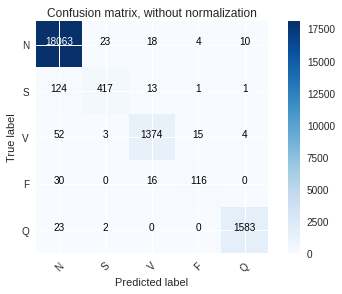

In [ ]:
y_pred = tf.argmax(m_resnet_model.predict(X_mitbihl_test), axis=-1)
# Compute confusion matrix
cnf_matrix = sklearn.metrics.confusion_matrix(y_mitbih_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['N', 'S', 'V', 'F', 'Q'],
                      title='Confusion matrix, without normalization')